# 分析

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier

from MLBDataFetcher import MLBDataFetcher
from preprocess import Att_Analysis

## 基礎分析

### ファイルの読み込み

観客者数がNaNになっていたり、同じ試合が重複しているものを削除して調整。  
・NaNになる理由  
---・試合が中止になった  
---・中止になった試合の移行試合が、翌日にダブルヘッダーの1試合目として行われた場合。なぜかは不明
---・翌日以外のダブルヘッダーや、単独で試合が行われた場合はNaNにならない
・重複している理由  
---・NaNになっていても、acquire_data.ipynbで観客者数を補完するとき、gameIDに対応する観客者数を入れているため、試合が順延になると同じgameIDの試合が生まれ、両方に観客者数を入れるため  

# Att_Analysisの使い方

## 観客者数を取得
・is_remove_covid, is_addupのオプションと共にインスタンス化して、.get_monthly_all_df()で取得

In [188]:
att_analysis = Att_Analysis(is_remove_covid=False, is_addup=True)
df = att_analysis.get_monthly_all_df()
df

,Attendance
2012-04,10085795
2012-05,12788090
2012-06,13484221
2012-07,12412394
2012-08,12942643
...,...
2023-05,11129758
2023-06,11787245
2023-07,11884189
2023-08,12340817


## 試合時間を取得

In [189]:
att_analysis.get_game_time()

,Game Time (minutes)
Year,
2012,180
2013,184
2014,187
2015,180
2016,184
2017,188
2018,184
2019,190
2021,192


## 観客者数を月毎にプロットする

### 各種関数

In [4]:
time_analysis = Att_Analysis(remove_covid=False)
game_time = time_analysis.get_game_time()
# 2022年以前の試合時間の平均
# game_time.iloc[:-1]
game_time_mean = game_time.iloc[:-1].mean()
game_time_mean

Game Time (minutes)    185.5
dtype: float64

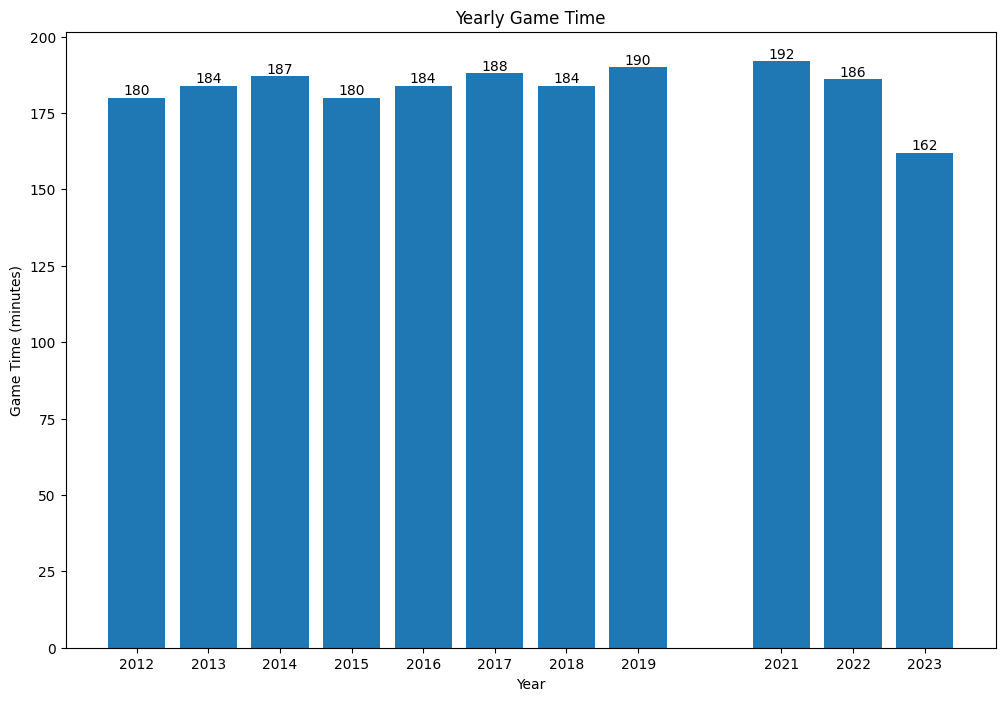

In [5]:
# すべての年の平均試合時間を棒グラフにする
# バーの上にその試合時間を表示
plt.figure(figsize=(12, 8))
plt.title('Yearly Game Time')
plt.xlabel('Year')
plt.ylabel('Game Time (minutes)')
plt.xticks(game_time.index, game_time.index)
for x, y in zip(game_time.index, game_time['Game Time (minutes)']):
    plt.text(x, y, y, ha='center', va='bottom')
plt.bar(game_time.index, game_time['Game Time (minutes)'])

plt.show()

In [6]:
import numpy as np
from scipy import stats

# 年毎の平均試合時間データ
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023]
game_times = [180, 184, 187, 180, 184, 188, 184, 190, 192, 186, 162]

# 2023年のデータとそれ以前のデータに分ける
game_time_2023 = game_times[years.index(2023)]
game_times_before_2023 = [time for i, time in enumerate(game_times) if years[i] != 2023]

# 1-sample t検定を実行
t_stat, p_value = stats.ttest_1samp(game_times_before_2023, game_time_2023)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

# p値が0.05より小さい場合、統計的に有意な差があると解釈
if p_value < 0.05:
    print("2023年の平均試合時間は統計的に有意に他の年に比べて短いです。")
else:
    print("2023年の平均試合時間は統計的に有意に他の年に比べて短くはありません。")


t-statistic: 18.94367482524118
p-value: 1.4644597583541207e-08
2023年の平均試合時間は統計的に有意に他の年に比べて短いです。


## 各種分析

### 観客者数について

In [7]:
# コロナ抜いたシーズンの合計数、715728106のはず？なんか合わない。attendance_analysis.get_covid_removed_df().sum()と比較して合わない
attendance_analysis_addup = Att_Analysis(addup=True, remove_covid=False)
attendance_analysis = Att_Analysis(addup=False, remove_covid=False)

# # Cleveland GuardiansとCleveland Indiansは合算
attendance_analysis.df.loc[attendance_analysis.df['Home Team'] == 'Cleveland Indians', 'Home Team'] = 'Cleveland Guardians'
attendance_analysis.df.loc[attendance_analysis.df['Away Team'] == 'Cleveland Indians', 'Away Team'] = 'Cleveland Guardians'
attendance_analysis_addup.df.loc[attendance_analysis_addup.df['Home Team'] == 'Cleveland Indians', 'Home Team'] = 'Cleveland Guardians'
attendance_analysis_addup.df.loc[attendance_analysis_addup.df['Away Team'] == 'Cleveland Indians', 'Away Team'] = 'Cleveland Guardians'

df_addup = attendance_analysis_addup.df_monthly_att_all
df = attendance_analysis.df_monthly_att_all

In [8]:
df_addup

,Attendance
2012-04,10085795
2012-05,12788090
2012-06,13484221
2012-07,12412394
2012-08,12942643
...,...
2023-05,11129758
2023-06,11787245
2023-07,11884189
2023-08,12340817


In [9]:
# 月別の平均観客数を集計
df_addup['Month'] = pd.to_datetime(df_addup.index, format='%Y-%m').strftime('%m')
df['Month'] = pd.to_datetime(df.index, format='%Y-%m').strftime('%m')


df_addup_mean = df_addup.groupby('Month').agg({'Attendance': 'mean'})
df_addup_mean

,Attendance
Month,
04,1.000938e+07
05,1.120550e+07
06,1.190291e+07
07,1.174210e+07
08,1.231368e+07
09,1.200747e+07


In [10]:
# 各年、各月のゲーム数を集計
# 横長に表示
# 整数で表示
df_tmp = attendance_analysis.df.groupby(['Year', 'Month']).agg({'Attendance': 'count'}).unstack().fillna(0).astype(int)
# df_tmp['sum'] = df_tmp.sum(axis=1)
df_tmp

df_tmp_addup = attendance_analysis_addup.df.groupby(['Year', 'Month']).agg({'Attendance': 'count'}).unstack().fillna(0).astype(int)


<Axes: title={'center': 'Number of Games per Month'}, xlabel='Year'>

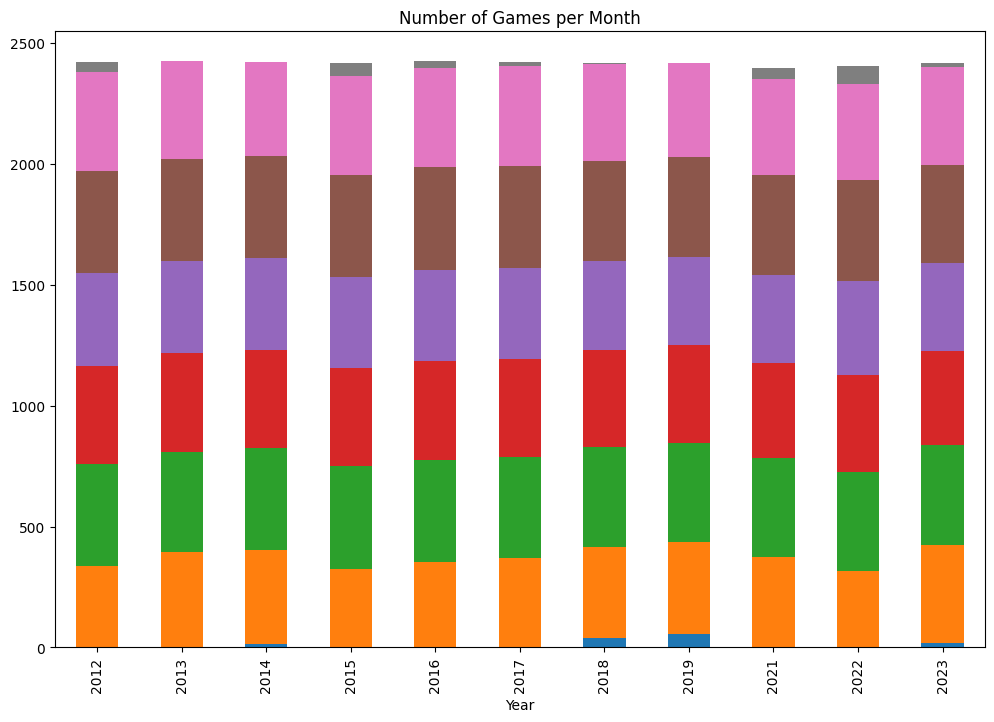

In [11]:
# 注釈は表示しない
df_tmp.plot(kind='bar', stacked=True, figsize=(12, 8), title='Number of Games per Month', legend=False)


<Axes: title={'center': 'Number of Games per Month'}, xlabel='Year'>

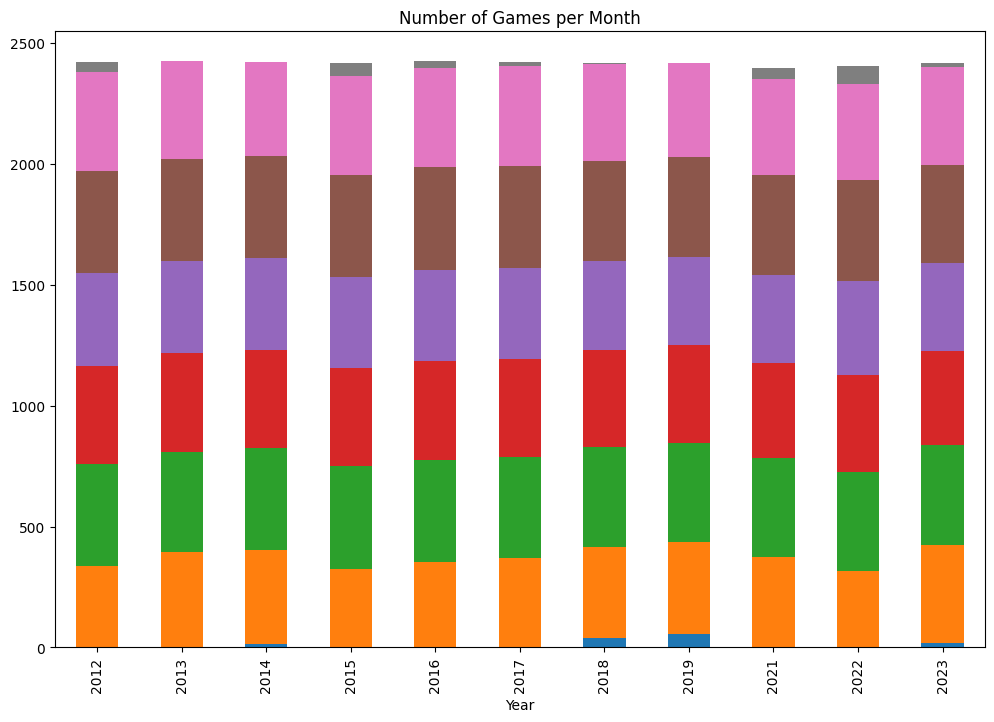

In [12]:
df_tmp_addup.plot(kind='bar', stacked=True, figsize=(12, 8), title='Number of Games per Month', legend=False)

In [13]:
# チームごとの平均観客者数を集計(ホームゲーム)
# 整数で表示


df_home_att = attendance_analysis.df.groupby('Home Team').agg({'Attendance': 'mean'}).sort_values(by='Attendance', ascending=False).astype(int)
df_away_att = attendance_analysis.df.groupby('Away Team').agg({'Attendance': 'mean'}).sort_values(by='Attendance', ascending=False).astype(int)
df_home_att

,Attendance
Home Team,
Los Angeles Dodgers,45312
St. Louis Cardinals,40599
New York Yankees,39522
San Francisco Giants,36678
Chicago Cubs,34995
Los Angeles Angels,34652
Boston Red Sox,34151
Colorado Rockies,33093
Milwaukee Brewers,31627


In [14]:
df_away_att

,Attendance
Away Team,
Los Angeles Dodgers,32553
Chicago Cubs,32027
San Francisco Giants,31650
New York Yankees,31177
San Diego Padres,30915
Pittsburgh Pirates,30578
Arizona Diamondbacks,30440
Cincinnati Reds,30026
Colorado Rockies,29971


<Axes: title={'center': 'Home Team Average Attendance'}, xlabel='Home Team'>

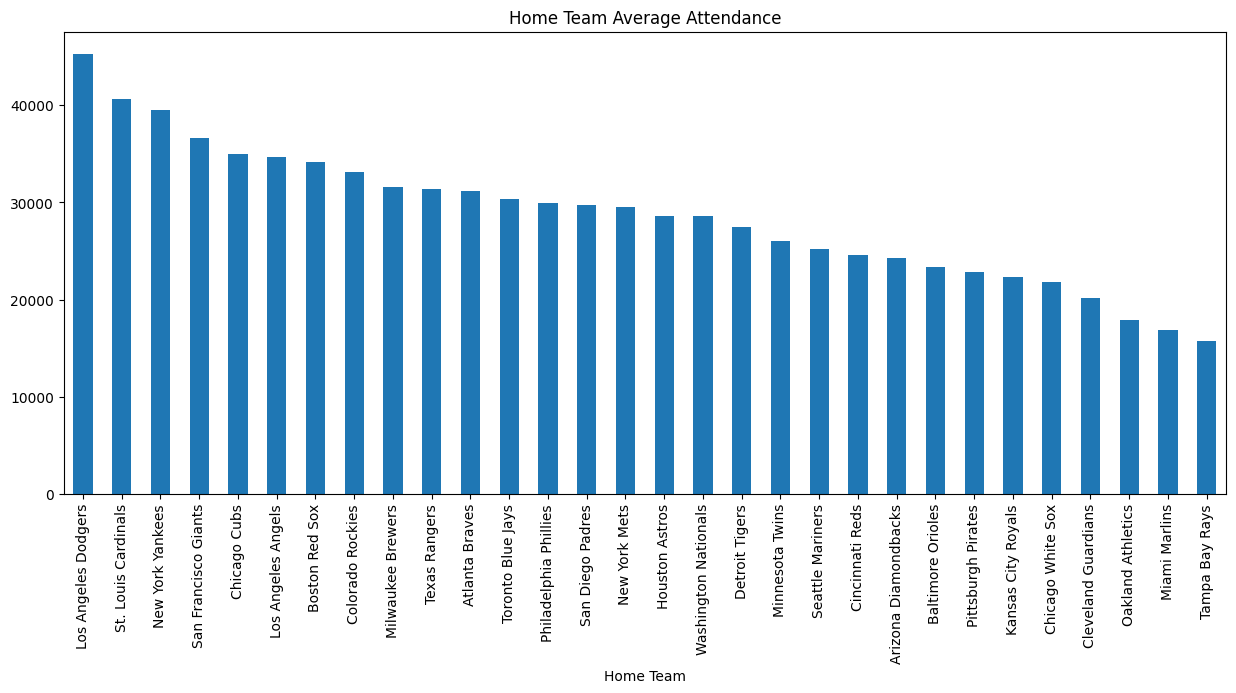

In [15]:
df_home_att.plot(kind='bar', figsize=(15, 6), title='Home Team Average Attendance', legend=False)

<Axes: title={'center': 'Home Team Average Attendance'}, xlabel='Year'>

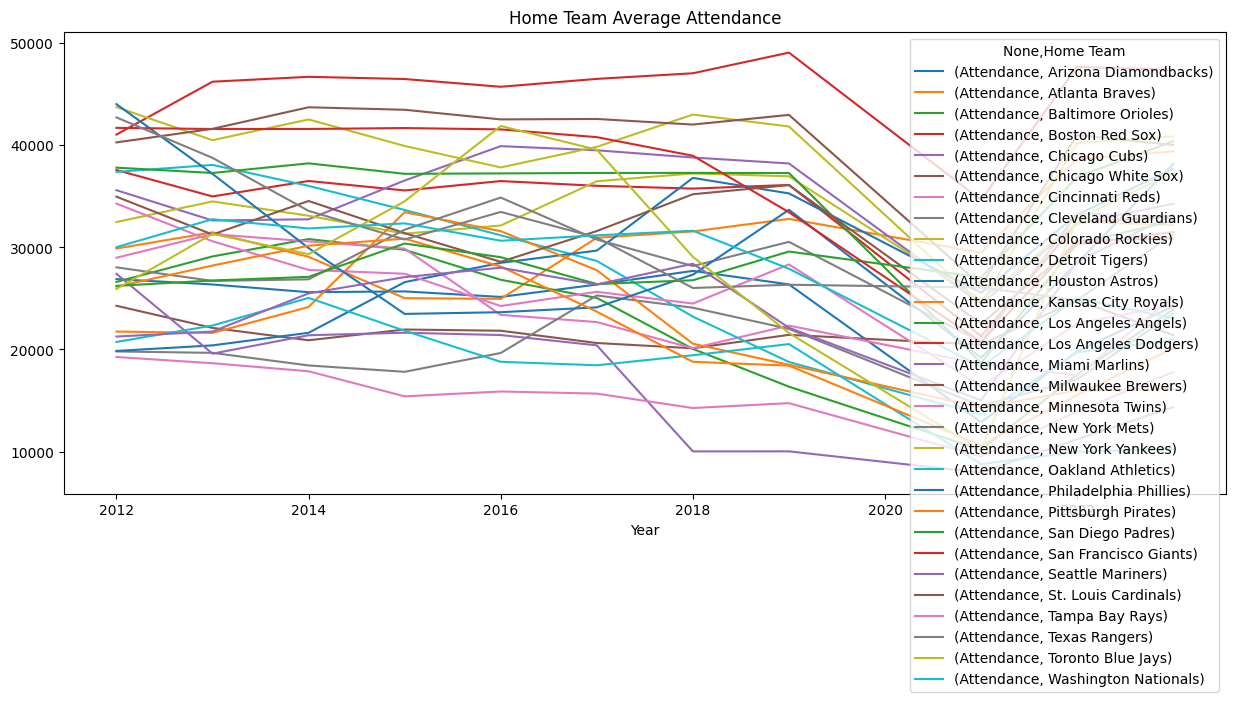

In [16]:
# チームごとの平均観客者数の推移
# 整数で表示
df_home_att_yearly = attendance_analysis.df.groupby(['Year', 'Home Team']).agg({'Attendance': 'mean'}).unstack().fillna(0).astype(int)
# 折れ線グラフ
# Cleveland GuardiansとCleveland Indiansは合算
# df_home_att_yearly['Attendance', 'Cleveland Guardians'] += df_home_att_yearly['Attendance', 'Cleveland Indians']
# df_home_att_yearly.drop(('Attendance', 'Cleveland Indians'), axis=1, inplace=True)
df_home_att_yearly

# 注釈は左に表示
df_home_att_yearly.plot(kind='line', figsize=(15, 6), title='Home Team Average Attendance', legend=True)
# df_home_att_yearly.plot(kind='line', figsize=(15, 6), title='Home Team Average Attendance', legend=False)




In [17]:
# 各球団の年毎の総観客数を集計
df_home_att_yearly_sum = attendance_analysis.df.groupby(['Year', 'Home Team']).agg({'Attendance': 'sum'}).unstack().fillna(0).astype(int)

df_home_att_yearly_sum

# 各球団の2022年までの平均合計観客者数を集計
# データフレームで表示
df_home_att_yearly_sum_mean = df_home_att_yearly_sum.iloc[:-1].mean().astype(int)
df_home_att_yearly_sum_mean = pd.DataFrame(df_home_att_yearly_sum_mean, columns=['Mean before 2022'])
# 2023年の観客者数の列を追加
df_home_att_yearly_sum_mean['2023'] = df_home_att_yearly_sum.iloc[-1]
# 2022年までの平均合計観客者数と2023年の観客者数を比較し、増減率の列を追加
# 小数第2位まで表示
df_home_att_yearly_sum_mean['Increase rate (%)'] = ((df_home_att_yearly_sum_mean['2023'] - df_home_att_yearly_sum_mean['Mean before 2022']) / df_home_att_yearly_sum_mean['Mean before 2022'] * 100).round(2)
# 増減率の列を降順にソート
df_home_att_yearly_sum_mean.sort_values(by='Increase rate (%)', ascending=False, inplace=True)

# df_home_att_yearly_sum_mean.plot(kind='bar', figsize=(15, 6), title='Home Team Average Attendance', legend=True)
df_home_att_yearly_sum_mean



Mean before 2022     2023  Increase rate (%)
           Home Team                                                          
Attendance San Diego Padres                2317979  3271554              41.14
           Seattle Mariners                1973947  2690418              36.30
           Houston Astros                  2247077  3052347              35.84
           Philadelphia Phillies           2333172  3052605              30.83
           Atlanta Braves                  2449177  3191505              30.31
           Toronto Blue Jays               2394143  3021904              26.22
           Cleveland Guardians             1571820  1834068              16.68
           Tampa Bay Rays                  1252680  1440301              14.98
           New York Mets                   2309243  2573555              11.45
           Los Angeles Dodgers             3658200  3837079               4.89
           Baltimore Orioles               1847922  1936798               4.81
           New York Yankees                3151110  3269016               3.74
           Cincinnati Reds                 1984762  2038302               2.70
           Arizona Diamondbacks            1966335  1961182              -0.26
           Milwaukee Brewers               2559668  2551347              -0.33
           Texas Rangers                   2542904  2533044              -0.39
           St. Louis Cardinals             3289290  3241091              -1.47
           Colorado Rockies                2671277  2607935              -2.37
           Chicago Cubs                    2844101  2775149              -2.42
           Boston Red Sox                  2775684  2672130              -3.73
           Chicago White Sox               1738122  1669628              -3.94
           Minnesota Twins                 2110452  1974124              -6.46
           Los Angeles Angels              2823445  2640575              -6.48
           Pittsburgh Pirates              1853229  1630624             -12.01
           Miami Marlins                   1382720  1162819             -15.90
           San Francisco Giants            3014376  2500153             -17.06
           Washington Nationals            2351068  1865832             -20.64
           Detroit Tigers                  2260671  1612876             -28.65
           Kansas City Royals              1851576  1307052             -29.41
           Oakland Athletics               1498250   832352             -44.45

In [18]:
# 2022年と2023年の観客者数をチームごとに比較
# 整数で表示
df_home_att_yearly_sum_2022_2023 = df_home_att_yearly_sum.iloc[-2:].T
df_home_att_yearly_sum_2022_2023['Increase rate (%)'] = ((df_home_att_yearly_sum_2022_2023[2023] - df_home_att_yearly_sum_2022_2023[2022]) / df_home_att_yearly_sum_2022_2023[2022] * 100).round(2)
df_home_att_yearly_sum_2022_2023['Increase number'] = df_home_att_yearly_sum_2022_2023[2023] - df_home_att_yearly_sum_2022_2023[2022]
df_home_att_yearly_sum_2022_2023.sort_values(by='Increase rate (%)', ascending=False, inplace=True)
df_home_att_yearly_sum_2022_2023


Year                                 2022     2023  Increase rate (%)   
           Home Team                                                    
Attendance Cincinnati Reds        1395770  2038302              46.03  \
           Baltimore Orioles      1368367  1936798              41.54   
           Cleveland Guardians    1295870  1834068              41.53   
           Philadelphia Phillies  2276736  3052605              34.08   
           Pittsburgh Pirates     1257458  1630624              29.68   
           Miami Marlins           907487  1162819              28.14   
           Tampa Bay Rays         1128127  1440301              27.67   
           Texas Rangers          2011361  2533044              25.94   
           Arizona Diamondbacks   1605199  1961182              22.18   
           Seattle Mariners       2287267  2690418              17.63   
           Toronto Blue Jays      2653830  3021904              13.87   
           Houston Astros         2688998  3052347              13.51   
           Minnesota Twins        1801128  1974124               9.60   
           San Diego Padres       2987470  3271554               9.51   
           Los Angeles Angels     2457461  2640575               7.45   
           Chicago Cubs           2616780  2775149               6.05   
           Oakland Athletics       787902   832352               5.64   
           Milwaukee Brewers      2422420  2551347               5.32   
           New York Yankees       3136207  3269016               4.23   
           Detroit Tigers         1575544  1612876               2.37   
           Kansas City Royals     1277686  1307052               2.30   
           Atlanta Braves         3129931  3191505               1.97   
           Boston Red Sox         2625089  2672130               1.79   
           San Francisco Giants   2482686  2500153               0.70   
           Colorado Rockies       2597428  2607935               0.40   
           New York Mets          2564737  2573555               0.34   
           Los Angeles Dodgers    3861408  3837079              -0.63   
           St. Louis Cardinals    3320551  3241091              -2.39   
           Washington Nationals   2026401  1865832              -7.92   
           Chicago White Sox      2009359  1669628             -16.91   

Year                              Increase number  
           Home Team                               
Attendance Cincinnati Reds                 642532  
           Baltimore Orioles               568431  
           Cleveland Guardians             538198  
           Philadelphia Phillies           775869  
           Pittsburgh Pirates              373166  
           Miami Marlins                   255332  
           Tampa Bay Rays                  312174  
           Texas Rangers                   521683  
           Arizona Diamondbacks            355983  
           Seattle Mariners                403151  
           Toronto Blue Jays               368074  
           Houston Astros                  363349  
           Minnesota Twins                 172996  
           San Diego Padres                284084  
           Los Angeles Angels              183114  
           Chicago Cubs                    158369  
           Oakland Athletics                44450  
           Milwaukee Brewers               128927  
           New York Yankees                132809  
           Detroit Tigers                   37332  
           Kansas City Royals               29366  
           Atlanta Braves                   61574  
           Boston Red Sox                   47041  
           San Francisco Giants             17467  
           Colorado Rockies                 10507  
           New York Mets                     8818  
           Los Angeles Dodgers             -24329  
           St. Louis Cardinals             -79460  
           Washington Nationals           -160569  
           Chicago White Sox              -339731

In [19]:
df_home_att_yearly_sum

Attendance                                    
Home Team Arizona Diamondbacks Atlanta Braves Baltimore Orioles   
Year                                                              
2012                   2177617        2420171           2102240  \
2013                   2134857        2548679           2357561   
2014                   2073730        2354305           2464473   
2015                   2080145        2001392           2320588   
2016                   2036216        2020914           2172344   
2017                   2134375        2505252           2028424   
2018                   2242695        2555781           1564192   
2019                   2135510        2655100           1307807   
2021                   1043010        2300247            793229   
2022                   1605199        3129931           1368367   
2023                   1961182        3191505           1936798   

                                                                          
Home Team Boston Red Sox Chicago Cubs Chicago White Sox Cincinnati Reds   
Year                                                                      
2012             3043003      2882756           1965955         2347251  \
2013             2833333      2642682           1768544         2534369   
2014             2956089      2652113           1650821         2476664   
2015             2880694      2959812           1755810         2419506   
2016             2955434      3232420           1746293         1894085   
2017             2917678      3199562           1629470         1836917   
2018             2895575      3181089           1608817         1629356   
2019             2924627      3094865           1649775         1808685   
2021             1725323      1978934           1596385         1505024   
2022             2625089      2616780           2009359         1395770   
2023             2672130      2775149           1669628         2038302   

                                                               ...   
Home Team Cleveland Guardians Colorado Rockies Detroit Tigers  ...   
Year                                                           ...   
2012                  1603596          2630458        3028033  ...  \
2013                  1572926          2793828        3083397  ...   
2014                  1437393          2680329        2917209  ...   
2015                  1388905          2506789        2726048  ...   
2016                  1591667          2602524        2493859  ...   
2017                  2048138          2953650        2321599  ...   
2018                  1926701          3015880        1856970  ...   
2019                  1738642          2993244        1501430  ...   
2021                  1114368          1938645        1102621  ...   
2022                  1295870          2597428        1575544  ...   
2023                  1834068          2607935        1612876  ...   

                                                                      
Home Team Philadelphia Phillies Pittsburgh Pirates San Diego Padres   
Year                                                                  
2012                    3565718            2091918          2123721  \
2013                    3012403            2256862          2166691   
2014                    2423852            2442564          2195373   
2015                    1831080            2498596          2459742   
2016                    1915144            2249201          2351422   
2017                    1905354            1919447          2138491   
2018                    2158124            1465316          2168536   
2019                    2727421            1491439          2396399   
2021                    1515890             859498          2191950   
2022                    2276736            1257458          2987470   
2023                    3052605            1630624          3271554   

                                                      

In [20]:
# 2022と2023の平均観客者数を比較
# 整数で表示
df_home_att_yearly_sum_2022_2023_mean = df_home_att_yearly_sum.iloc[-2:].astype(int).T
# df_home_att_yearly_sum_2022_2023_mean
df_home_att_yearly_sum_2022_2023_mean = (df_home_att_yearly_sum_2022_2023_mean/81).astype(int)
df_home_att_yearly_sum_2022_2023_mean['Increase rate (%)'] = ((df_home_att_yearly_sum_2022_2023_mean[2023] - df_home_att_yearly_sum_2022_2023_mean[2022]) / df_home_att_yearly_sum_2022_2023_mean[2022] * 100).round(2)
df_home_att_yearly_sum_2022_2023_mean['Increase number'] = df_home_att_yearly_sum_2022_2023_mean[2023] - df_home_att_yearly_sum_2022_2023_mean[2022]
df_home_att_yearly_sum_2022_2023_mean.sort_values(by='Increase rate (%)', ascending=False, inplace=True)
df_home_att_yearly_sum_2022_2023_mean

Year                               2022   2023  Increase rate (%)   
           Home Team                                                
Attendance Cincinnati Reds        17231  25164              46.04  \
           Baltimore Orioles      16893  23911              41.54   
           Cleveland Guardians    15998  22642              41.53   
           Philadelphia Phillies  28107  37686              34.08   
           Pittsburgh Pirates     15524  20131              29.68   
           Miami Marlins          11203  14355              28.14   
           Tampa Bay Rays         13927  17781              27.67   
           Texas Rangers          24831  31272              25.94   
           Arizona Diamondbacks   19817  24212              22.18   
           Seattle Mariners       28237  33215              17.63   
           Toronto Blue Jays      32763  37307              13.87   
           Houston Astros         33197  37683              13.51   
           Minnesota Twins        22236  24371               9.60   
           San Diego Padres       36882  40389               9.51   
           Los Angeles Angels     30339  32599               7.45   
           Chicago Cubs           32305  34261               6.05   
           Oakland Athletics       9727  10275               5.63   
           Milwaukee Brewers      29906  31498               5.32   
           New York Yankees       38718  40358               4.24   
           Detroit Tigers         19451  19912               2.37   
           Kansas City Royals     15773  16136               2.30   
           Atlanta Braves         38641  39401               1.97   
           Boston Red Sox         32408  32989               1.79   
           San Francisco Giants   30650  30866               0.70   
           Colorado Rockies       32067  32196               0.40   
           New York Mets          31663  31772               0.34   
           Los Angeles Dodgers    47671  47371              -0.63   
           St. Louis Cardinals    40994  40013              -2.39   
           Washington Nationals   25017  23034              -7.93   
           Chicago White Sox      24806  20612             -16.91   

Year                              Increase number  
           Home Team                               
Attendance Cincinnati Reds                   7933  
           Baltimore Orioles                 7018  
           Cleveland Guardians               6644  
           Philadelphia Phillies             9579  
           Pittsburgh Pirates                4607  
           Miami Marlins                     3152  
           Tampa Bay Rays                    3854  
           Texas Rangers                     6441  
           Arizona Diamondbacks              4395  
           Seattle Mariners                  4978  
           Toronto Blue Jays                 4544  
           Houston Astros                    4486  
           Minnesota Twins                   2135  
           San Diego Padres                  3507  
           Los Angeles Angels                2260  
           Chicago Cubs                      1956  
           Oakland Athletics                  548  
           Milwaukee Brewers                 1592  
           New York Yankees                  1640  
           Detroit Tigers                     461  
           Kansas City Royals                 363  
           Atlanta Braves                     760  
           Boston Red Sox                     581  
           San Francisco Giants               216  
           Colorado Rockies                   129  
           New York Mets                      109  
           Los Angeles Dodgers               -300  
           St. Louis Cardinals               -981  
           Washington Nationals             -1983  
           Chicago White Sox                -4194

In [21]:
# 2023年の導入前後のデータを分ける
df_pre_2023 = df[df['Date'] < '2023-01-01']
df_post_2023 = df[df['Date'] >= '2023-01-01']

# 同じ月のデータを取得
# 2023年のデータが完全ではない可能性があるため、2023年の存在する月だけを取得
common_months = df_post_2023['Date'].dt.month.unique()
df_pre_2023 = df_pre_2023[df_pre_2023['Date'].dt.month.isin(common_months)]

# 最新の年（2022年）のデータを取得
df_pre_2023 = df_pre_2023[df_pre_2023['Date'].dt.year == 2022]

# 導入前後の観客者数の差を計算
attendance_diff = df_post_2023['Attendance'].reset_index(drop=True) - df_pre_2023['Attendance'].reset_index(drop=True)

attendance_diff


KeyError: 'Date'

In [ ]:
from scipy import stats

# ペアードt検定を実施
t_stat, p_value = stats.ttest_rel(df_post_2023['Attendance'], df_pre_2023['Attendance'])

t_stat, p_value


### 試合時間について

## 中断時系列分析を行う

In [176]:
att_remove_covid_addup = Att_Analysis(remove_covid=True, addup=True)
df_att_remove_covid_addup = att_remove_covid_addup.get_monthly_all_df()

In [177]:
df_att_remove_covid_addup

,Attendance
2012-04,10085795
2012-05,12788090
2012-06,13484221
2012-07,12412394
2012-08,12942643
2012-09,13146125
2013-04,11327161
2013-05,12423877
2013-06,12753480
2013-07,12406872


## 設計
入力: DataFrame (月毎の観客数)、介入時期（何年何月か）、中断時系列分析に用いる手法（線形回帰、ARIMA、SARIMA、、、）  

関数:  
    ・__init__(): 初期化  
    ・separate_data(): 介入前と介入後のデータに分ける  
    ・plot_data(): データをプロットする  
    ・prepare_data(): データを準備する  
    ・fit(): 実行する手法を選択する  
    ・fit_ols(): 線形回帰でデータをフィッティングする  
    ・summary_ols(): 線形回帰の結果を表示する  
    ・fit_arima(): ARIMAでデータをフィッティングする  
    ・summary_arima(): ARIMAの結果を表示する  
    ・fit_sarima(): SARIMAでデータをフィッティングする  
    ・summary_sarima(): SARIMAの結果を表示する  
    ・plot_predict(): 予測値をプロットする  
    ・plot_predict_all(): すべての手法の予測値をプロットする  
    ・plot_predict_all(): すべての手法の予測値をプロットする  

In [ ]:
class ITS:
    """中断時系列分析を行うクラス
    """
    def __init__(self, df, intervention, method):
        self.df = df # インスタンスに渡された元のデータフレーム
        self.df_before = None # 介入前のデータフレーム
        self.df_after = None # 介入後のデータフレーム
        self.df_its = None # 分析用のデータフレーム

        self.intervention = intervention
        self.method = method

        self.model = None # モデルを格納する
        self.model_name = None # モデルの名前を格納する

        self.separate_data()

    def separate_data(self):
        """介入前と介入後のデータに分ける
        """
        self.df_before = self.df[self.df.index < self.intervention]
        self.df_after = self.df[self.df.index >= self.intervention]
        return self.df_before, self.df_after

    def plot_data(self):
        """介入前と介入後のデータをプロットする
        """
        plt.figure(figsize=(12, 8))
        plt.title('Monthly Attendance')
        plt.xlabel('Month')
        plt.ylabel('Attendance')
        plt.xticks(rotation=90)
        plt.scatter(self.df_before.index, self.df_before['Attendance'], color='red', label='Monthly Attendance (before intervention)')
        plt.scatter(self.df_after.index, self.df_after['Attendance'], color='blue', label='Monthly Attendance (after intervention)')
        plt.plot(self.df_before['Attendance'], color='red')
        plt.plot(self.df_after['Attendance'], color='blue')
        plt.legend()
        plt.show()

    def prepare_data(self):
        """データフレームを準備する。介入前後のダミー変数、月のインデックス、そして介入後に1ずつ増えていく列を追加
        """
        self.df_its = self.df
        self.df_its['time since start'] = [i for i in range(0, self.df_its.shape[0])]
        # self.interventionが何番目の行かを取得
        self.intervention_index = self.df_its.index.get_loc(self.intervention)
        # 介入前後のダミー変数を追加
        # self.intervention_index以降は1、それ以前は0
        # 短期的な影響を見る
        self.df_its['level change'] = [0 if i < self.intervention_index else 1 for i in range(self.df_its.shape[0])]
        # 介入後は1ずつ増えていく列を追加
        # 長期的な影響を見る
        self.df_its['slope change'] = [i - self.intervention_index if i >= self.intervention_index else 0 for i in range(self.df_its.shape[0])]
        return self.df_its

    def fit(self):
        """中断時系列分析に用いる手法を選択する
        Option:
            OLS: 線形回帰
            SARIMA: SARIMA
            ARIMA: ARIMA
        """
        if self.method == 'OLS':
            self.fit_ols()
        elif self.method == 'SARIMA':
            self.fit_sarima()
        elif self.method == 'ARIMA':
            self.fit_arima()
        else:
            print('Please select method from OLS, SARIMA, ARIMA')

    def fit_ols(self):
        """線形回帰で中断時系列分析を行う
        """
        if self.df_its is None:
            self.prepare_data()

        X = sm.add_constant(self.df_its.reset_index()[['time since start', 'level change', 'slope change']])
        y = self.df_its.reset_index()['Attendance']
        self.model = sm.OLS(y, X).fit()
        self.model_name = 'OLS'

    def fit_sarima(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        """SARIMAで中断時系列分析を行う

        Args:
            order (tuple, optional): _description_. Defaults to (1, 1, 1).
            seasonal_order (tuple, optional): _description_. Defaults to (1, 1, 1, 12).

        Returns:
            _type_: _description_
        """
        self.model_name = "SARIMA"

        self.model = SARIMAX(self.df_before['Attendance'], order=order, seasonal_order=seasonal_order) #? 他のパラメータ、orderとseasonal_orderとは？どうやって決める？
        results = self.model.fit(disp=False) #? dispって何？
        return results

    def fit_arima(self):
        self.model_name = "ARIMA"
        return print('ARIMA')

    def show_summary(self):
        """結果を表示する
        """
        if self.model is None:
            self.fit()
        # モデルの名前が現在のモデルと異なる場合も実行
        if self.model_name != self.method:
            self.fit()

        return self.model.summary()

    def plot_predict(self, alpha=0.05, is_counterfactual=False, is_prediction_std=False):
        """予測結果を図示する
        """
        if self.model is None:
            self.fit()
        # モデルの名前が現在のモデルと異なる場合も実行
        if self.model_name != self.method:
            self.fit()

        # 予測結果を取得
        pred = self.model.predict()

        # 予測結果をプロット
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12, 8))
        plt.title('Predicted Monthly Attendance')
        plt.xlabel('Month')
        plt.ylabel('Attendance')
        plt.xticks(rotation=90)
        plt.plot(self.df.index, self.df['Attendance'], color='red')
        plt.scatter(self.df.index, self.df['Attendance'], color='red', label='Monthly Attendance (before intervention)')
        plt.plot(pred, color='blue', label='Predicted Monthly Attendance')

        if is_counterfactual:
            # 反実仮想を取得
            counterfactual = self.calc_counterfactual()
            plt.plot(counterfactual, color='green', label='Counterfactual Monthly Attendance')
        if is_prediction_std:
            # 信頼区間を取得
            st, data, ss2 = summary_table(self.model, alpha=alpha)
            y_predict_l, y_predict_u = data[:, 4:6].T
            plt.plot(y_predict_l, color='orange', linestyle='--', label=f'Lower {(1-alpha)*100}% Confidence Interval', alpha=0.5)
            plt.plot(y_predict_u, color='orange', linestyle='--', label=f'Upper {(1-alpha)*100}% Confidence Interval', alpha=0.5)


            if is_counterfactual:
                cf_predict_l = counterfactual - (pred - y_predict_l)
                cf_predict_u = counterfactual - (pred - y_predict_u)
                plt.plot(cf_predict_l, color='purple', linestyle='--', label=f'Lower {(1-alpha)*100}% Confidence Interval for Counterfactual', alpha=0.5)
                plt.plot(cf_predict_u, color='purple', linestyle='--', label=f'Upper {(1-alpha)*100}% Confidence Interval for Counterfactual', alpha=0.5)

        plt.axvline(self.intervention, color='black', linestyle='-.', label='Intervention Date')
        plt.legend()
        plt.show()

    def calc_counterfactual(self):
        """反実仮想を計算する
        """
        # 反実仮想用のデータフレームを作成
        cf_data = self.df_its[['time since start', 'level change', 'slope change']].copy(deep=True)
        cf_data['level change'] = 0
        cf_data['slope change'] = 0

        # 反事実を予測
        cf_data.insert(0, 'cep', [1]*len(cf_data)) # 定数の列を追加
        y_cf_predict = self.model.predict(cf_data)

        return y_cf_predict

In [46]:
class ITS:
    """中断時系列分析を行うクラス
    """
    def __init__(self, df, intervention, method, interaction=False, period=6, order=3, optim_params_periodic_ols=False):
        """
        Args:
            DataFrame関連
                df (DataFrame): 中断時系列分析を行うためのデータフレーム。インデックスは日付、列は観客数
                df_before (DataFrame): 介入前のデータフレーム。dfと同じ形式
                df_after (DataFrame): 介入後のデータフレーム。dfと同じ形式
                df_its (DataFrame): OLSで分析するためのデータフレーム。t, xt, t*xtの列を持つ（時間のインデックス、level change、slope change）
                df_period (DataFrame): Periodic OLSで分析するためのデータフレーム。t, xt, t*xt, sin(2πt/period), cos(2πt/period)の列を持つ（時間のインデックス、level change、slope change、sin、cos）

            モデルの設定
                全体
                    intervention (string): 介入が行われた日付。日付の形式は'YYYY-MM'
                    method (string): 中断時系列分析に用いる手法。'OLS', 'SARIMA', 'ARIMA', 'Periodic OLS'から選択
                    interaction (bool, optional): 交互作用項を考慮するかどうか。time since startとlevel changeの。Defaults to False.
                    model: モデルを格納する
                    model_name: モデルの名前を格納する

                Periodic OLS
                    period (int, optional): 周期性のパラメータ。何期で1周期とするか。Defaults to 6.（4月から9月までなので6でちょうどよい）
                    order (int, optional): フーリエで何次元まで使うかどうかのパラメータ。Defaults to 3.
                    optim_params_periodic_ols (bool, optional): パラメータを最適化するかどうか。Defaults to False.

                OLS
                    variables(list): OLSで用いる変数のリスト。['time since start', 'level change', 'slope change']がデフォルト。t, xt, t*xt

        Functions:
            前処理関連
                separate_data(): 介入前と介入後のデータに分ける
                prepare_data(): モデルで学習できるようにデータを準備する。OLS用、交互作用考慮
                prepare_data_for_period_ols(): Periodic OLSのためのデータを準備する。t, xt, t*xt, sin, cosの列を持つデータフレームを作成し、self.df_periodに格納する #! これ、prepare_data()に統合できたら綺麗だよね


            描画関連
                plot_data(): 介入前と介入後のデータをプロットする。ただただdfをプロットするだけ
                plot_predict(alpha: 何%の信頼区間を描画するか,
                            is_counterfactual: 反事実も描画するかどうか,
                            is_prediction_std: 学習・予測の信頼区間を表示するかどうか): モデルで学習・予測した結果をプロット。
                calc_counterfactual(): 反実仮想を計算する。level changeとslope changeを0にしたデータフレームを作成し、モデルで予測する。もし介入してなかったら、どうなっていたかを出力

            学習関連
                fit(): 中断時系列分析に用いる手法を選択し、学習する。とりあえずfit()しておけば、model.methodに基づいて設定したモデルで学習する
                fit_ols(): 線形回帰で中断時系列分析を行う
                fit_slope_after_intervention(): 介入後の傾き（β_1 + β_3）についてsummaryを出す。
                fit_sarima(): SARIMAで中断時系列分析を行う
                fit_arima(): ARIMAで中断時系列分析を行う
                fit_periodic_ols(): Periodic OLSで中断時系列分析を行う

            モデル関連
                Periodic OLS
                    optim_params_periodic_ols(): 周期回帰に使うperiodとorderをR^2スコアが最大になるようにパラメータを最適化する。#! これは後でちゃんと作ろう。今は手動でパラメータを決めている

            結果確認
                show_summary(): とりあえずこれを呼び出せば、model.methodに基づいて設定したモデルのsummaryを出す。
        """
        self.df = df # インスタンスに渡された元のデータフレーム
        self.df_before = None # 介入前のデータフレーム
        self.df_after = None # 介入後のデータフレーム
        self.df_its = None # 分析用のデータフレーム
        self.df_period = None # Periodic OLSの分析のためのデータフレーム

        self.intervention = intervention
        self.method = method
        self.interaction = interaction

        self.period = period
        self.order = order

        self.model = None # モデルを格納する
        self.model_name = None # モデルの名前を格納する

        self.separate_data()
        self.variables = ['time since start', 'level change', 'slope change'] # t, xt, t*xt

        self.optim_params_periodic_ols=optim_params_periodic_ols

    def separate_data(self):
        """介入前と介入後のデータに分ける
        """
        self.df_before = self.df[self.df.index < self.intervention]
        self.df_after = self.df[self.df.index >= self.intervention]
        return self.df_before, self.df_after

    def plot_data(self):
        """介入前と介入後のデータをプロットする
        """
        plt.figure(figsize=(12, 8))
        plt.title('Monthly Attendance')
        plt.xlabel('Month')
        plt.ylabel('Attendance')
        plt.xticks(rotation=90)
        plt.scatter(self.df_before.index, self.df_before['Attendance'], color='red', label='Monthly Attendance (before intervention)')
        plt.scatter(self.df_after.index, self.df_after['Attendance'], color='blue', label='Monthly Attendance (after intervention)')
        plt.plot(self.df_before['Attendance'], color='red')
        plt.plot(self.df_after['Attendance'], color='blue')
        plt.legend()
        plt.show()

    def prepare_data(self):
        """データフレームを準備する。介入前後のダミー変数、月のインデックス、そして介入後に1ずつ増えていく列を追加
        """

        if self.interaction:
            self.variables.append('level change * time since start')
        self.df_its = self.df
        self.df_its[self.variables[0]] = [i for i in range(0, self.df_its.shape[0])] # time since start
        # self.interventionが何番目の行かを取得
        self.intervention_index = self.df_its.index.get_loc(self.intervention)
        # 介入前後のダミー変数を追加
        # self.intervention_index以降は1、それ以前は0
        # 短期的な影響を見る level change
        self.df_its[self.variables[1]] = [0 if i < self.intervention_index else 1 for i in range(self.df_its.shape[0])] # level change
        # 介入後は1ずつ増えていく列を追加
        # 長期的な影響を見る slope change
        self.df_its[self.variables[2]] = [i - self.intervention_index if i >= self.intervention_index else 0 for i in range(self.df_its.shape[0])] # slope change

        # 交互作用項を追加
        if self.interaction:
            self.df_its[self.variables[3]] = self.df_its[self.variables[1]] * self.df_its[self.variables[0]] # level change * time since start
        return self.df_its

    def fit_slope_after_intervention(self):
        """介入後の傾きについての列を追加（β_1 + β_3）
        データフレームに追加し、介入後の傾きが有意かを確認する
        x*txが有意であれば、介入後の傾きは有意であると言える
        """
        self.prepare_data()
        # 介入後の傾きについての列を追加（β_1 + β_3）
        self.df_its_1_3 = self.df_its.copy(deep=True)
        self.df_its_1_3['t(1-xt)'] = self.df_its[self.variables[0]] * (1- self.df_its[self.variables[1]])
        self.df_its_1_3['t*xt'] = self.df_its[self.variables[0]] * self.df_its[self.variables[1]]

        X = self.df_its_1_3[['t(1-xt)', 't*xt', self.variables[1]]]
        y = self.df_its_1_3['Attendance']

        mod2 = sm.OLS(y, sm.add_constant(X))
        res2 = mod2.fit()
        print(res2.summary())
        return self.df_its_1_3

    def fit(self):
        """中断時系列分析に用いる手法を選択する
        Option:
            OLS: 線形回帰
            Periodic OLS: 周期回帰
            SARIMA: SARIMA
            ARIMA: ARIMA
        """
        if self.method == 'OLS':
            self.fit_ols()
        elif self.method == 'Periodic OLS':
            self.fit_periodic_ols()
        elif self.method == 'SARIMA':
            self.fit_sarima()
        elif self.method == 'ARIMA':
            self.fit_arima()
        else:
            print('Please select method from OLS, SARIMA, ARIMA')

    def fit_ols(self):
        """線形回帰で中断時系列分析を行う
        """
        if self.df_its is None:
            self.prepare_data()

        X = sm.add_constant(self.df_its.reset_index()[[self.variables[0], self.variables[1], self.variables[2]]])
        if self.interaction:
            X = sm.add_constant(self.df_its.reset_index()[[self.variables[0], self.variables[1], self.variables[2], self.variables[3]]])
        y = self.df_its.reset_index()['Attendance']
        self.model = sm.OLS(y, X).fit()
        self.model_name = 'OLS'

    def prepare_data_for_period_ols(self):
        """周期回帰のためのデータを用意する
        """
        if self.df_its is None:
            self.prepare_data()
        self.df_period = self.df_its.copy(deep=True)

        # 周期period, order次までのフーリエ級数を用意する
        fourier = Fourier(period=self.period, order=self.order)

        # データをDeteministicProcessにより生成
        dp = DeterministicProcess(
            index=self.df_period.index,
            order=0,
            period=self.period,
            # fourier=fourier,
            drop=True,
            constant=False,
            additional_terms=[fourier]
        )

        H = dp.in_sample()

        self.df_period = pd.concat([self.df_period, H], axis=1)

    def optim_params_period_ols(self):
        """周期回帰に使う最適パラメータを探索する
        self.period, self.orderを最適化する
        R^2値が最大となるようにしたい
        #! これは後でかな。
        """
        return 6, 3
        # return period, order

    def fit_periodic_ols(self):
        """周期回帰で中断時系列分析を行う
        """
        if self.df_period is None:
            self.prepare_data_for_period_ols()

        # 最適パラメータを探索
        if self.optim_params_periodic_ols:
            self.period, self.order = self.optim_params_periodic_ols()

        row_list = [self.variables[i] for i in range(len(self.variables))]
        # 'sin(1,6)', cos(1,6)', 'sin(2,6)', 'cos(2,6)', 'sin(3,6)', 'cos(3,6)'のように列名を作成
        sin_cos_list = [f'sin({i},{self.period})' for i in range(1, self.order+1)] + [f'cos({i},{self.period})' for i in range(1, self.order+1)]
        row_list.extend(sin_cos_list)
        X = sm.add_constant(self.df_period.reset_index()[row_list])
        y = self.df_period.reset_index()['Attendance']

        # モデルを作成
        self.model = sm.OLS(y, sm.add_constant(X)).fit()
        # 訓練
        self.model_name = 'Periodic OLS'

    def fit_sarima(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        """SARIMAで中断時系列分析を行う

        Args:
            order (tuple, optional): _description_. Defaults to (1, 1, 1).
            seasonal_order (tuple, optional): _description_. Defaults to (1, 1, 1, 12).

        Returns:
            _type_: _description_
        """
        self.model_name = "SARIMA"

        self.model = SARIMAX(self.df_before['Attendance'], order=order, seasonal_order=seasonal_order) #? 他のパラメータ、orderとseasonal_orderとは？どうやって決める？
        results = self.model.fit(disp=False) #? dispって何？
        return results

    def fit_arima(self):
        self.model_name = "ARIMA"
        return print('ARIMA')

    def show_summary(self):
        """結果を表示する
        """
        if self.model is None:
            self.fit()
        # モデルの名前が現在のモデルと異なる場合も実行
        if self.model_name != self.method:
            self.fit()

        return self.model.summary()

    def plot_predict(self, alpha=0.05, is_counterfactual=False, is_prediction_std=False):
        """予測結果を図示する
        """
        if self.model is None:
            self.fit()
        # モデルの名前が現在のモデルと異なる場合も実行
        if self.model_name != self.method:
            self.fit()

        # 予測結果を取得
        pred = self.model.predict()

        # 予測結果をプロット
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12, 8))
        plt.title('Predicted Monthly Attendance')
        plt.xlabel('Month')
        plt.ylabel('Attendance')
        plt.xticks(rotation=90)
        plt.plot(self.df.index, self.df['Attendance'], color='red')
        plt.scatter(self.df.index, self.df['Attendance'], color='red', label='Monthly Attendance (before intervention)')
        plt.plot(pred, color='blue', label='Predicted Monthly Attendance')

        if is_counterfactual:
            # 反実仮想を取得
            counterfactual = self.calc_counterfactual()
            # 介入後のデータのみをプロット
            plt.plot(counterfactual[self.intervention_index:], color='green', label='Counterfactual Monthly Attendance')
            # plt.plot(counterfactual, color='green', label='Counterfactual Monthly Attendance')
        if is_prediction_std:
            # 信頼区間を取得
            st, data, ss2 = summary_table(self.model, alpha=alpha)
            y_predict_l, y_predict_u = data[:, 4:6].T
            plt.plot(y_predict_l, color='orange', linestyle='--', label=f'Lower {(1-alpha)*100}% Confidence Interval', alpha=0.5)
            plt.plot(y_predict_u, color='orange', linestyle='--', label=f'Upper {(1-alpha)*100}% Confidence Interval', alpha=0.5)


            if is_counterfactual:
                cf_predict_l = counterfactual - (pred - y_predict_l)
                cf_predict_u = counterfactual - (pred - y_predict_u)
                plt.plot(cf_predict_l[self.intervention_index:], color='purple', linestyle='--', label=f'Lower {(1-alpha)*100}% Confidence Interval for Counterfactual', alpha=0.5)
                plt.plot(cf_predict_u[self.intervention_index:], color='purple', linestyle='--', label=f'Upper {(1-alpha)*100}% Confidence Interval for Counterfactual', alpha=0.5)

        plt.axvline(self.intervention, color='black', linestyle='-.', label='Intervention Date')
        plt.legend()
        plt.show()

    def calc_counterfactual(self):
        """反実仮想を計算する
        """
        if self.df_its is None:
            self.prepare_data()

        if self.df_period is None:
            self.prepare_data_for_period_ols()

        if self.method == 'OLS':
            cf_data = self.df_its[[self.variables[0], self.variables[1], self.variables[2]]].copy(deep=True)
            if self.interaction:
                cf_data = self.df_its[[self.variables[0], self.variables[1], self.variables[2], self.variables[3]]].copy(deep=True)

        if self.method == 'Periodic OLS':
            cf_data = self.df_period.drop(columns=['Attendance'])

        cf_data['level change'] = 0
        cf_data['slope change'] = 0

        # 反事実を予測
        cf_data.insert(0, 'cep', [1]*len(cf_data)) # 定数の列を追加
        y_cf_predict = self.model.predict(cf_data)

        return y_cf_predict

In [47]:
df_att_remove_covid_addup = Att_Analysis(remove_covid=True, addup=True).df_monthly_att_all_addup_covid_removed

its_periodical_OLS = ITS(df_att_remove_covid_addup, intervention='2023-04', method='Periodic OLS', period=6, order=3)
its_OLS = ITS(df_att_remove_covid_addup, intervention='2023-04', method='OLS', interaction=False)
#* R^2値が最大になるように、パラメータを自動探索したい


In [49]:
# its.plot_predict(is_counterfactual=True, is_prediction_std=True)
its_OLS.fit_slope_after_intervention()

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     4.393
Date:                Sun, 22 Oct 2023   Prob (F-statistic):            0.00760
Time:                        21:50:17   Log-Likelihood:                -906.19
No. Observations:                  60   AIC:                             1820.
Df Residuals:                      56   BIC:                             1829.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.267e+07   2.44e+05     51.980   

,Attendance,time since start,level change,slope change,t(1-xt),t*xt
2012-04,10085795,0,0,0,0,0
2012-05,12788090,1,0,0,1,0
2012-06,13484221,2,0,0,2,0
2012-07,12412394,3,0,0,3,0
2012-08,12942643,4,0,0,4,0
2012-09,13146125,5,0,0,5,0
2013-04,11327161,6,0,0,6,0
2013-05,12423877,7,0,0,7,0
2013-06,12753480,8,0,0,8,0
2013-07,12406872,9,0,0,9,0


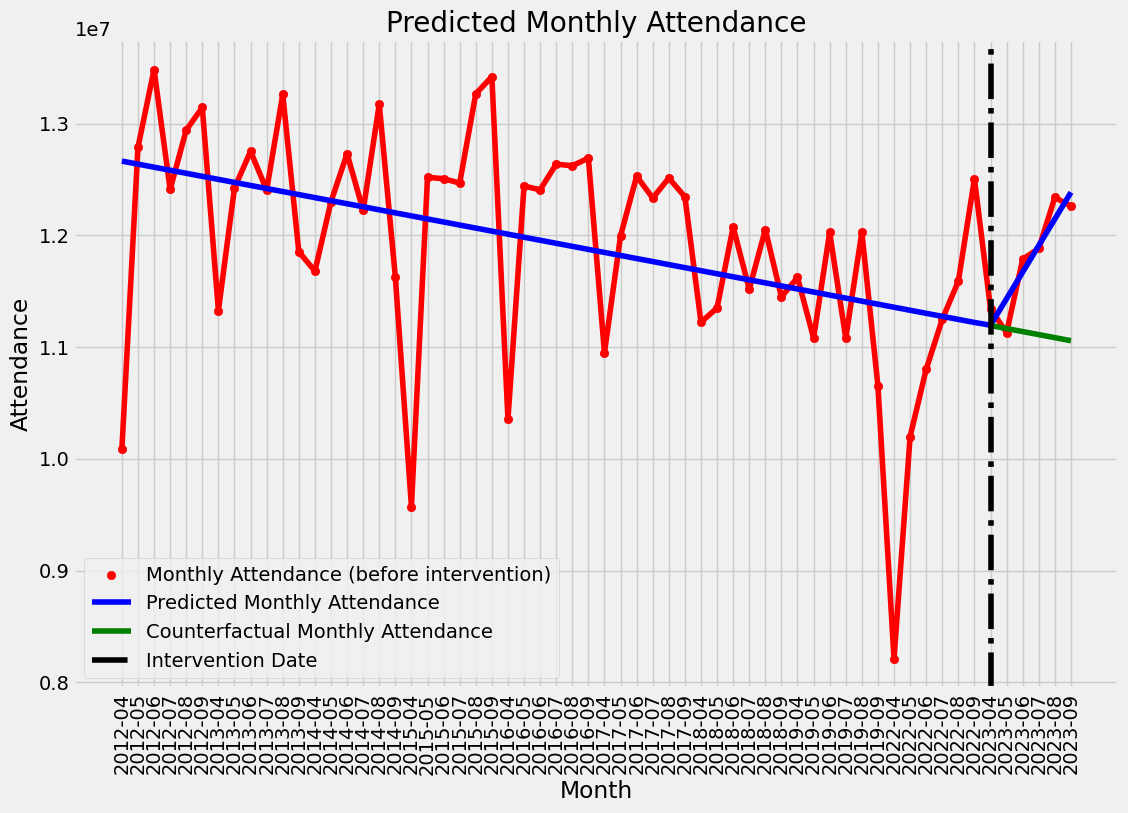

In [ ]:
its_OLS.plot_predict(is_counterfactual=True)

In [ ]:
its_periodical_OLS.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     10.88
Date:                Mon, 16 Oct 2023   Prob (F-statistic):           8.76e-09
Time:                        17:40:14   Log-Likelihood:                -882.66
No. Observations:                  60   AIC:                             1783.
Df Residuals:                      51   BIC:                             1802.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.277e+07   1.73e+05     73.668      0.000    1.24e+07    1.31e+07
time since start -3.104e+04   5645.303     -5.498      0.000   -4.24e+04   -1.97e+04
level change      8.938e+05   5.19e+05      1.723      0.091   -1.48e+05    1.94e+06
slope change     -4.595e+04   1.62e+05     -0.284      0.778   -3.71e+05    2.79e+05
sin(1,6)         -2.468e+05   1.21e+05     -2.039      0.047    -4.9e+05   -3807.288
sin(2,6)         -5.047e+04   1.18e+05     -0.429      0.670   -2.87e+05    1.86e+05
sin(3,6)          1.991e-08   5.29e-09      3.768      0.000     9.3e-09    3.05e-08
cos(1,6)         -6.425e+05   1.19e+05     -5.418      0.000   -8.81e+05   -4.04e+05
cos(2,6)         -6.344e+05   1.19e+05     -5.350      0.000   -8.72e+05   -3.96e+05
cos(3,6)         -1.035e+05   8.34e+04     -1.241      0.220   -2.71e+05    6.39e+04
==============================================================================
Omnibus:                        3.527   Durbin-Watson:                   1.540
Prob(Omnibus):                  0.171   Jarque-Bera (JB):                2.605
Skew:                          -0.385   Prob(JB):                        0.272
Kurtosis:                       3.669   Cond. No.                     3.50e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.74e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

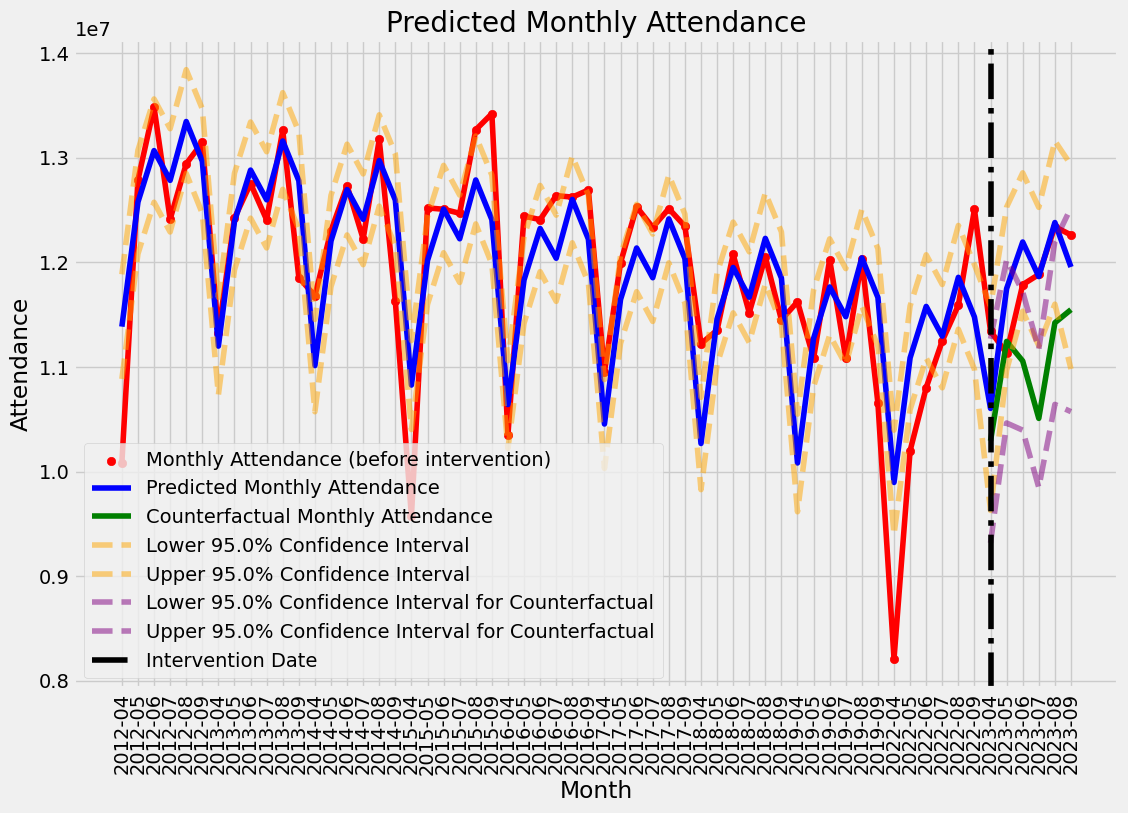

In [ ]:
its_periodical_OLS.plot_predict(is_counterfactual=True, is_prediction_std=True)

In [ ]:
# 使うDFを変える
df_att_remove_covid = Att_Analysis(remove_covid=True, addup=False).df_monthly_att_all_covid_removed
its_periodical_OLS = ITS(df_att_remove_covid, intervention='2023-04', method='Periodic OLS', period=8, order=3)
its_periodical_OLS.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.240
Date:                Mon, 16 Oct 2023   Prob (F-statistic):              0.288
Time:                        18:11:28   Log-Likelihood:                -1211.9
No. Observations:                  73   AIC:                             2444.
Df Residuals:                      63   BIC:                             2467.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.075e+07   1.03e+06     10.442      0.000     8.7e+06    1.28e+07
time since start -2.924e+04   2.74e+04     -1.069      0.289   -8.39e+04    2.54e+04
level change       4.51e+06    3.2e+06      1.411      0.163   -1.88e+06    1.09e+07
slope change     -1.063e+06   8.45e+05     -1.258      0.213   -2.75e+06    6.25e+05
sin(1,8)         -1.321e+06   7.24e+05     -1.826      0.073   -2.77e+06    1.25e+05
sin(2,8)          1.109e+06   7.05e+05      1.572      0.121   -3.01e+05    2.52e+06
sin(3,8)           3.14e+05   7.05e+05      0.445      0.658   -1.09e+06    1.72e+06
cos(1,8)         -5.582e+05   7.13e+05     -0.783      0.436   -1.98e+06    8.66e+05
cos(2,8)         -6.591e+05      7e+05     -0.941      0.350   -2.06e+06     7.4e+05
cos(3,8)           -6.1e+05   6.96e+05     -0.877      0.384      -2e+06    7.81e+05
==============================================================================
Omnibus:                       13.868   Durbin-Watson:                   1.305
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.864
Skew:                          -1.133   Prob(JB):                     0.000359
Kurtosis:                       3.284   Cond. No.                         277.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

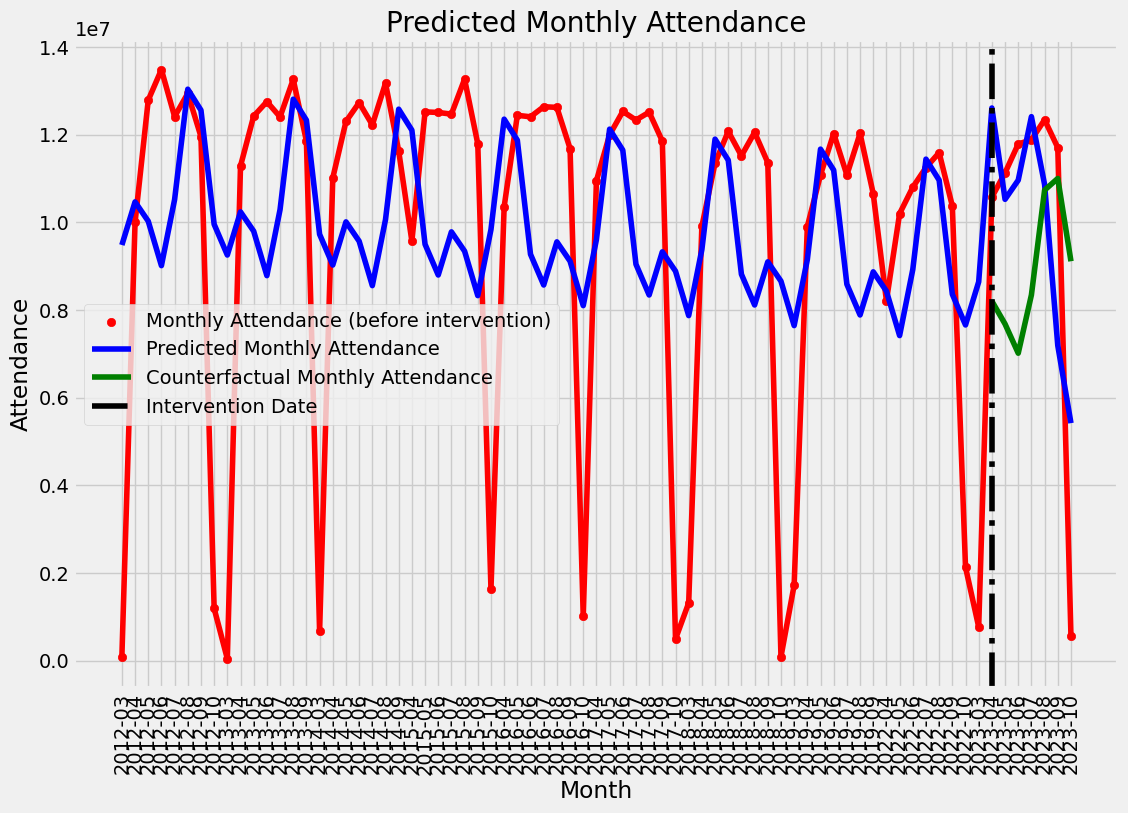

In [ ]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

### 2022年のデータを排除した上でやってみる

In [ ]:
# 2022年のデータも除外した上でやってみる
# 2022年のデータを除外したデータフレームを作成
df_att_remove_covid_addup_2022_removed = df_att_remove_covid_addup[df_att_remove_covid_addup.index < '2022-04']
# 2023年のデータを結合
df_att_remove_covid_addup_2022_removed = pd.concat([df_att_remove_covid_addup_2022_removed, df_att_remove_covid_addup[df_att_remove_covid_addup.index >= '2023-04']])

its_periodical_OLS_2022_removed = ITS(df_att_remove_covid_addup_2022_removed, intervention='2023-04', method='Periodic OLS', period=6, order=3)
its_OLS_2022_removed = ITS(df_att_remove_covid_addup_2022_removed, intervention='2023-04', method='OLS', interaction=True)

In [ ]:
its_periodical_OLS_2022_removed.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     8.790
Date:                Mon, 16 Oct 2023   Prob (F-statistic):           3.84e-07
Time:                        18:04:50   Log-Likelihood:                -787.12
No. Observations:                  54   AIC:                             1592.
Df Residuals:                      45   BIC:                             1610.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.264e+07   1.62e+05     77.937      0.000    1.23e+07     1.3e+07
time since start  -2.32e+04   5955.189     -3.895      0.000   -3.52e+04   -1.12e+04
level change      2.967e+05   4.64e+05      0.639      0.526   -6.38e+05    1.23e+06
slope change      1.179e+04   1.44e+05      0.082      0.935   -2.78e+05    3.01e+05
sin(1,6)         -1.443e+05   1.13e+05     -1.276      0.209   -3.72e+05    8.35e+04
sin(2,6)          2882.7327    1.1e+05      0.026      0.979   -2.18e+05    2.24e+05
sin(3,6)          3.011e-09   2.75e-09      1.096      0.279   -2.52e-09    8.54e-09
cos(1,6)         -5.894e+05    1.1e+05     -5.335      0.000   -8.12e+05   -3.67e+05
cos(2,6)         -5.727e+05    1.1e+05     -5.184      0.000   -7.95e+05    -3.5e+05
cos(3,6)         -4.407e+04   7.77e+04     -0.567      0.573      -2e+05    1.12e+05
==============================================================================
Omnibus:                        3.915   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                2.908
Skew:                          -0.431   Prob(JB):                        0.234
Kurtosis:                       3.742   Cond. No.                     3.81e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.52e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

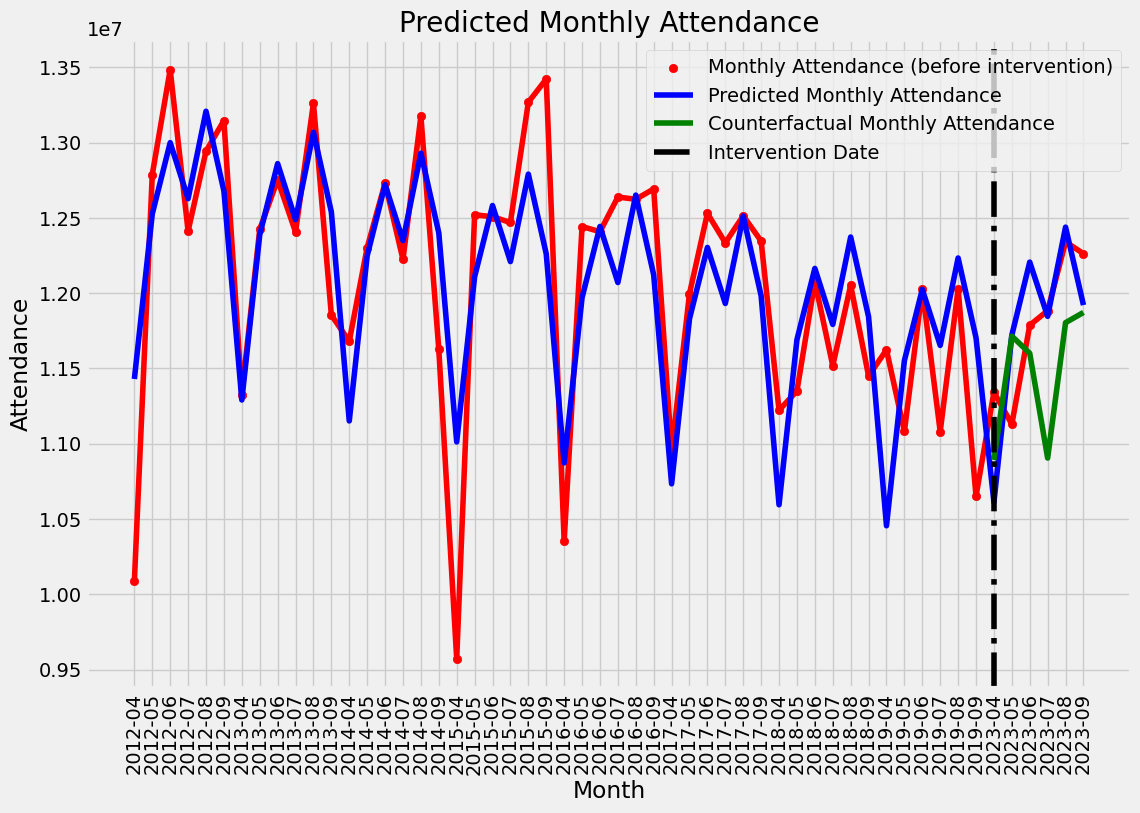

In [ ]:
its_periodical_OLS_2022_removed.plot_predict(is_counterfactual=True)

In [ ]:
its_OLS_2022_removed.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.560
Date:                Mon, 16 Oct 2023   Prob (F-statistic):             0.0654
Time:                        18:06:44   Log-Likelihood:                -808.67
No. Observations:                  54   AIC:                             1625.
Df Residuals:                      50   BIC:                             1633.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.255e+07   2.28e+05     55.044      0.000    1.21e+07     1.3e+07
time since start                -1.941e+04   8356.107     -2.322      0.024   -3.62e+04   -2622.817
level change                    -5720.1439   4416.629     -1.295      0.201   -1.46e+04    3150.916
slope change                     2.659e+05   2.02e+05      1.318      0.194   -1.39e+05    6.71e+05
level change * time since start -8618.8787    1.3e+04     -0.664      0.510   -3.47e+04    1.74e+04
==============================================================================
Omnibus:                       21.397   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.536
Skew:                          -1.378   Prob(JB):                     1.42e-07
Kurtosis:                       5.533   Cond. No.                     1.01e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.53e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

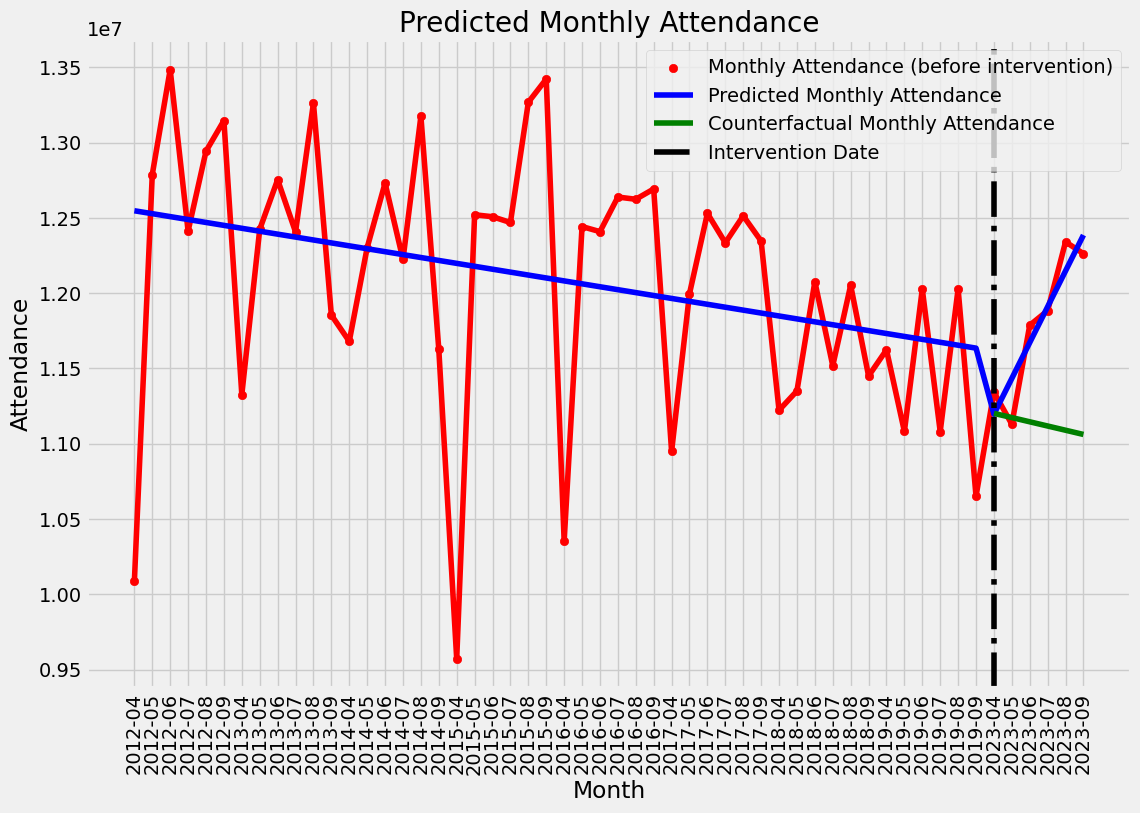

In [ ]:
its_OLS_2022_removed.plot_predict(is_counterfactual=True)

## Multi Interrupted Time Series Analysis

In [151]:
class MITS:
    """中断時系列分析を行うクラス。複数の介入点を設定できる
    """
    def __init__(self, df, interventions, method, interaction=False, period=6, order=3, optim_params_periodic_ols=False):
        """
        Args:
            DataFrame関連
                df (DataFrame): 中断時系列分析を行うためのデータフレーム。インデックスは日付、列は観客数
                df_before (DataFrame): 介入前のデータフレーム。dfと同じ形式
                df_after (DataFrame): 介入後のデータフレーム。dfと同じ形式
                df_its (DataFrame): OLSで分析するためのデータフレーム。t, xt, t*xtの列を持つ（時間のインデックス、level change、slope change）
                df_period (DataFrame): Periodic OLSで分析するためのデータフレーム。t, xt, t*xt, sin(2πt/period), cos(2πt/period)の列を持つ（時間のインデックス、level change、slope change、sin、cos）

            モデルの設定
                全体
                    interventions (list of string): 介入が行われた日付。複数指定可能。日付の形式は'YYYY-MM'
                    method (string): 中断時系列分析に用いる手法。'OLS', 'SARIMA', 'ARIMA', 'Periodic OLS'から選択
                    interaction (bool, optional): 交互作用項を考慮するかどうか。time since startとlevel changeの。Defaults to False.
                    model: モデルを格納する
                    model_name: モデルの名前を格納する

                Periodic OLS
                    period (int, optional): 周期性のパラメータ。何期で1周期とするか。Defaults to 6.（4月から9月までなので6でちょうどよい）
                    order (int, optional): フーリエで何次元まで使うかどうかのパラメータ。Defaults to 3.
                    optim_params_periodic_ols (bool, optional): パラメータを最適化するかどうか。Defaults to False.

                OLS
                    variables(list): OLSで用いる変数のリスト。['time since start', 'level change', 'slope change']がデフォルト。t, xt, t*xt

        Functions:
            前処理関連
                separate_data(): 介入前と介入後のデータに分ける
                prepare_data(): モデルで学習できるようにデータを準備する。OLS用、交互作用考慮
                prepare_data_for_period_ols(): Periodic OLSのためのデータを準備する。t, xt, t*xt, sin, cosの列を持つデータフレームを作成し、self.df_periodに格納する #! これ、prepare_data()に統合できたら綺麗だよね


            描画関連
                plot_data(): 介入前と介入後のデータをプロットする。ただただdfをプロットするだけ
                plot_predict(alpha: 何%の信頼区間を描画するか,
                            is_counterfactual: 反事実も描画するかどうか,
                            is_prediction_std: 学習・予測の信頼区間を表示するかどうか): モデルで学習・予測した結果をプロット。
                calc_counterfactual(): 反実仮想を計算する。level changeとslope changeを0にしたデータフレームを作成し、モデルで予測する。もし介入してなかったら、どうなっていたかを出力

            学習関連
                fit(): 中断時系列分析に用いる手法を選択し、学習する。とりあえずfit()しておけば、model.methodに基づいて設定したモデルで学習する
                fit_ols(): 線形回帰で中断時系列分析を行う
                fit_slope_after_intervention(): 介入後の傾き（β_1 + β_3）についてsummaryを出す。
                fit_sarima(): SARIMAで中断時系列分析を行う
                fit_arima(): ARIMAで中断時系列分析を行う
                fit_periodic_ols(): Periodic OLSで中断時系列分析を行う

            モデル関連
                Periodic OLS
                    optim_params_periodic_ols(): 周期回帰に使うperiodとorderをR^2スコアが最大になるようにパラメータを最適化する。#! これは後でちゃんと作ろう。今は手動でパラメータを決めている

            結果確認
                show_summary(): とりあえずこれを呼び出せば、model.methodに基づいて設定したモデルのsummaryを出す。

            #!工事中
                ・交互作用項の実装
                ・パラメータ最適化の実装
        """
        self.df = df # インスタンスに渡された元のデータフレーム
        self.df_its = None # 分析用のデータフレーム
        self.df_period = None # Periodic OLSの分析のためのデータフレーム

        self.intervention = interventions
        self.num_interventions = len(interventions)
        self.method = method
        self.interaction = interaction

        self.period = period
        self.order = order

        self.model = None # モデルを格納する
        self.model_name = None # モデルの名前を格納する

        # self.separate_data()
        # self.variables = ['time since start', 'level change', 'slope change'] # t, xt, t*xt

        self.optim_params_periodic_ols=optim_params_periodic_ols

    def separate_data(self):
        """介入ごとのデータに分ける
        Returns:
            list of DataFrame: 介入ごとのデータフレームを返す
        """
        # self.intervention+1個のデータフレームを作成し、すべて返す
        dfs = []
        for i in range(self.num_interventions+1):
            if i == 0:
                dfs.append(self.df[self.df.index < self.intervention[i]])
            elif i == self.num_interventions:
                dfs.append(self.df[self.df.index >= self.intervention[i-1]])
            else:
                dfs.append(self.df[(self.df.index >= self.intervention[i-1]) & (self.df.index < self.intervention[i])])
        return dfs

    def plot_data(self):
        """介入ごとのデータをプロットする
        """
        dfs = self.separate_data()
        plt.figure(figsize=(12, 8))
        plt.title('Monthly Attendance')
        plt.xlabel('Month')
        plt.ylabel('Attendance')
        plt.xticks(rotation=90)
        for i in range(self.num_interventions+1):
            plt.scatter(dfs[i].index, dfs[i]['Attendance'], label=f'Monthly Attendance (intervention {i})')
            plt.plot(dfs[i]['Attendance'])
        plt.legend()
        plt.show()

    def prepare_data(self):
        """データフレームを準備する。介入前後のダミー変数、月のインデックス、そして介入後に1ずつ増えていく列を追加。介入点ごとに変数を追加
        #! 交互作用項の実装なし
        """
        self.df_its = self.df
        # time indexは介入の数によらないので、ここで追加
        self.df_its[f'time since start'] = [j for j in range(1, self.df_its.shape[0]+1)] # time since start
        # 介入ごとに変数を追加
        for i in range(self.num_interventions):
            # self.interventionが何番目の行かを取得
            intervention_index = self.df_its.index.get_loc(self.intervention[i])
            # 介入前後のダミー変数を追加
            # self.intervention_index以降は1、それ以前は0
            # 短期的な影響を見る level change
            self.df_its[f'level change {i}'] = [0 if j < intervention_index else 1 for j in range(self.df_its.shape[0])]
            # 介入後は1ずつ増えていく列を追加
            # 長期的な影響を見る slope change
            self.df_its[f'slope change {i}'] = [j - intervention_index if j >= intervention_index else 0 for j in range(1, self.df_its.shape[0]+1)]
        return self.df_its

    def fit_slope_after_intervention(self):
        """介入後の傾きについての列を追加（β_1 + β_3 + β_5 + ...）
        データフレームに追加し、介入後の傾きが有意かを確認する
        t*X_itが有意であれば、i番目の介入後の傾きは有意であると言える
        t*(X_i-1t - X_it)が有意であれば、i-1番目からi番目の間の傾きが有意であると言える
        例: 2022-04, 2023-04の2回の介入があった場合、t*X_2023-04t, t*(X_2022-04t - X_2023-04t)を追加
        t*X_2023-04tが有意であれば、2023-04の介入後の傾きは有意であると言える。
        t*(X_2022-04t - X_2023-04t)が有意であれば、2022-04から2023-04の間の傾きが有意であると言える。
        #! 周期回帰の場合はどうする？
        #! 交互作用項の実装なし
        """
        self.prepare_data()
        # 介入後の傾きについての列を追加
        self.df_its_slope = self.df_its.copy(deep=True)
        for i in range(self.num_interventions):
            if i == 0:
                self.df_its_slope[f't*(1 - level change {i})'] = (1-self.df_its_slope[f'level change {i}']) * self.df_its_slope['time since start']
            else:
                self.df_its_slope[f't*(level change {i-1} - level change {i})'] = (self.df_its_slope[f'level change {i-1}']-self.df_its_slope[f'level change {i}']) * self.df_its_slope['time since start']
                self.df_its_slope[f'level change {i-1} - level change {i}'] = (self.df_its_slope[f'level change {i-1}']-self.df_its_slope[f'level change {i}'])
            # 最後に追加
            if i == self.num_interventions-1:
                self.df_its_slope[f't*level change {i}'] = self.df_its_slope[f'level change {i}'] * self.df_its_slope['time since start']

        rows = ['t*(1 - level change 0)', f't*level change {self.num_interventions-1}', f'level change {self.num_interventions-1}']
        rows += [f't*(level change {i-1} - level change {i})' for i in range(1, self.num_interventions)]
        rows += [f'level change {i-1} - level change {i}' for i in range(1, self.num_interventions)]
        X = self.df_its_slope[rows]
        # X = self.df_its_1_3[['t(1-xt)', 't*xt', self.variables[1]]]
        y = self.df_its_slope['Attendance']

        mod2 = sm.OLS(y, sm.add_constant(X))
        res2 = mod2.fit()
        print(res2.summary())
        # return X

    def fit(self):
        """中断時系列分析に用いる手法を選択する
        Option:
            OLS: 線形回帰
            Periodic OLS: 周期回帰
            SARIMA: SARIMA
            ARIMA: ARIMA
        """
        if self.method == 'OLS':
            self.fit_ols()
        elif self.method == 'Periodic OLS':
            self.fit_periodic_ols()
        elif self.method == 'SARIMA':
            self.fit_sarima()
        elif self.method == 'ARIMA':
            self.fit_arima()
        else:
            print('Please select method from OLS, Periodic OLS, SARIMA, ARIMA')

    def fit_ols(self):
        """線形回帰で中断時系列分析を行う
        """
        if self.df_its is None:
            self.prepare_data()

        X = sm.add_constant(self.df_its.reset_index().drop(columns=['index', 'Attendance']))
        # if self.interaction:
        #     X = sm.add_constant(self.df_its.reset_index()[[self.variables[0], self.variables[1], self.variables[2], self.variables[3]]])
        y = self.df_its.reset_index()['Attendance']
        self.model = sm.OLS(y, X).fit()
        self.model_name = 'OLS'

    def prepare_data_for_period_ols(self):
        """周期回帰のためのデータを用意する
        """
        if self.df_its is None:
            self.prepare_data()
        self.df_period = self.df_its.copy(deep=True)

        # 周期period, order次までのフーリエ級数を用意する
        fourier = Fourier(period=self.period, order=self.order)

        # データをDeteministicProcessにより生成
        dp = DeterministicProcess(
            index=self.df_period.index,
            order=0,
            period=self.period,
            # fourier=fourier,
            drop=True,
            constant=False,
            additional_terms=[fourier]
        )

        H = dp.in_sample()

        self.df_period = pd.concat([self.df_period, H], axis=1)

    def optim_params_period_ols(self):
        """周期回帰に使う最適パラメータを探索する
        self.period, self.orderを最適化する
        R^2値が最大となるようにしたい
        #! これは後でかな。
        """
        return 6, 3
        # return period, order

    def fit_periodic_ols(self):
        """周期回帰で中断時系列分析を行う
        """
        if self.df_period is None:
            self.prepare_data_for_period_ols()

        # 最適パラメータを探索
        if self.optim_params_periodic_ols:
            self.period, self.order = self.optim_params_periodic_ols()

        # row_list = [self.variables[i] for i in range(len(self.variables))]
        # 'sin(1,6)', cos(1,6)', 'sin(2,6)', 'cos(2,6)', 'sin(3,6)', 'cos(3,6)'のように列名を作成
        # sin_cos_list = [f'sin({i},{self.period})' for i in range(1, self.order+1)] + [f'cos({i},{self.period})' for i in range(1, self.order+1)]
        # row_list.extend(sin_cos_list)
        X = sm.add_constant(self.df_period.reset_index().drop(columns=['index', 'Attendance']))
        y = self.df_period.reset_index()['Attendance']
        # print(X)
        # print(y)
        # モデルを作成
        self.model = sm.OLS(y, sm.add_constant(X)).fit()
        # 訓練
        self.model_name = 'Periodic OLS'

    def fit_sarima(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        """SARIMAで中断時系列分析を行う

        Args:
            order (tuple, optional): _description_. Defaults to (1, 1, 1).
            seasonal_order (tuple, optional): _description_. Defaults to (1, 1, 1, 12).

        Returns:
            _type_: _description_
        #! ここは未改修。self.df_beforeとかないし。
        """
        self.model_name = "SARIMA"

        self.model = SARIMAX(self.df_before['Attendance'], order=order, seasonal_order=seasonal_order) #? 他のパラメータ、orderとseasonal_orderとは？どうやって決める？
        results = self.model.fit(disp=False) #? dispって何？
        return results

    def fit_arima(self):
        self.model_name = "ARIMA"
        return print('ARIMA')

    def show_summary(self):
        """結果を表示する
        """
        if self.model is None:
            self.fit()
        # モデルの名前が現在のモデルと異なる場合も実行
        if self.model_name != self.method:
            self.fit()

        return self.model.summary()

    def plot_predict(self, alpha=0.05, is_counterfactual=False, is_prediction_std=False):
        """予測結果を図示する
        """
        if self.model is None:
            self.fit()
        # モデルの名前が現在のモデルと異なる場合も実行
        if self.model_name != self.method:
            self.fit()

        # 予測結果を取得
        pred = self.model.predict()

        # 予測結果をプロット
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12, 8))
        plt.title('Predicted Monthly Attendance')
        plt.xlabel('Month')
        plt.ylabel('Attendance')
        plt.xticks(rotation=90)
        plt.plot(self.df.index, self.df['Attendance'], color='red')
        plt.scatter(self.df.index, self.df['Attendance'], color='red', label='Monthly Attendance (before intervention)')
        plt.plot(pred, color='blue', label='Predicted Monthly Attendance')

        if is_counterfactual:
            # 反実仮想を取得
            counterfactual = self.calc_counterfactual()
            # 介入後のデータのみをプロット
            for i in range(self.num_interventions):
                intervention_idx_ = self.df_its.index.get_loc(self.intervention[i])
                plt.plot(counterfactual[intervention_idx_:], color='green', label=f'{i} Counterfactual Monthly Attendance')
        if is_prediction_std:
            # 信頼区間を取得
            st, data, ss2 = summary_table(self.model, alpha=alpha)
            y_predict_l, y_predict_u = data[:, 4:6].T
            plt.plot(y_predict_l, color='orange', linestyle='--', label=f'Lower {(1-alpha)*100}% Confidence Interval', alpha=0.5)
            plt.plot(y_predict_u, color='orange', linestyle='--', label=f'Upper {(1-alpha)*100}% Confidence Interval', alpha=0.5)


            if is_counterfactual:
                cf_predict_l = counterfactual - (pred - y_predict_l)
                cf_predict_u = counterfactual - (pred - y_predict_u)
                for i in range(self.num_interventions):
                    intervention_idx_ = self.df_its.index.get_loc(self.intervention[i])
                    plt.plot(cf_predict_l[intervention_idx_:], color='purple', linestyle='--', label=f'Lower {(1-alpha)*100}% Confidence Interval for Counterfactual', alpha=0.5)
                    plt.plot(cf_predict_u[intervention_idx_:], color='purple', linestyle='--', label=f'Upper {(1-alpha)*100}% Confidence Interval for Counterfactual', alpha=0.5)

        for i in range(self.num_interventions):
            plt.axvline(self.intervention[i], color='black', linestyle='-.', label=f'Intervention Date {i}')

        plt.legend()
        plt.show()

    def calc_counterfactual(self):
        """反実仮想を計算する
        """
        if self.df_its is None:
            self.prepare_data()

        if self.df_period is None:
            self.prepare_data_for_period_ols()

        if self.method == 'OLS':
            cf_data = self.df_its.reset_index().drop(columns=['index', 'Attendance']).copy(deep=True)
            # if self.interaction:
            #     cf_data = self.df_its[[self.variables[0], self.variables[1], self.variables[2], self.variables[3]]].copy(deep=True)

        if self.method == 'Periodic OLS':
            cf_data = self.df_period.drop(columns=['Attendance'])

        for i in range(self.num_interventions):
            cf_data[f'level change {i}'] = 0
            cf_data[f'slope change {i}'] = 0

        # 反事実を予測
        cf_data.insert(0, 'cep', [1]*len(cf_data)) # 定数の列を追加
        y_cf_predict = self.model.predict(cf_data)

        return y_cf_predict

In [169]:
test_df = Att_Analysis(remove_covid=True, addup=True).df_monthly_att_all_addup_covid_removed

test_mits = MITS(test_df, interventions=['2022-04', '2023-04'], method='Periodic OLS', period=6, order=3)


In [170]:
test_mits.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     13.71
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           4.33e-11
Time:                        01:05:15   Log-Likelihood:                -872.49
No. Observations:                  60   AIC:                             1767.
Df Residuals:                      49   BIC:                             1790.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.266e+07   1.63e+05     77.560      0.000    1.23e+07     1.3e+07
time since start  -2.32e+04   5810.013     -3.992      0.000   -3.49e+04   -1.15e+04
level change 0   -2.524e+06   5.68e+05     -4.440      0.000   -3.67e+06   -1.38e+06
slope change 0    5.196e+05    1.4e+05      3.703      0.001    2.38e+05    8.02e+05
level change 1   -1.694e+05   7.11e+05     -0.238      0.813    -1.6e+06    1.26e+06
slope change 1   -5.078e+05   1.87e+05     -2.715      0.009   -8.84e+05   -1.32e+05
sin(1,6)         -1.332e+05   1.08e+05     -1.236      0.222    -3.5e+05    8.34e+04
cos(1,6)         -5.769e+05   1.03e+05     -5.583      0.000   -7.85e+05   -3.69e+05
sin(2,6)         -1.261e+04   1.02e+05     -0.124      0.902   -2.17e+05    1.92e+05
cos(2,6)         -5.688e+05   1.03e+05     -5.504      0.000   -7.76e+05   -3.61e+05
sin(3,6)         -2.098e-08    1.8e-08     -1.163      0.250   -5.72e-08    1.53e-08
cos(3,6)         -7.072e+04   7.23e+04     -0.979      0.333   -2.16e+05    7.45e+04
==============================================================================
Omnibus:                        5.116   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                4.284
Skew:                          -0.482   Prob(JB):                        0.117
Kurtosis:                       3.885   Cond. No.                     3.71e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.38e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

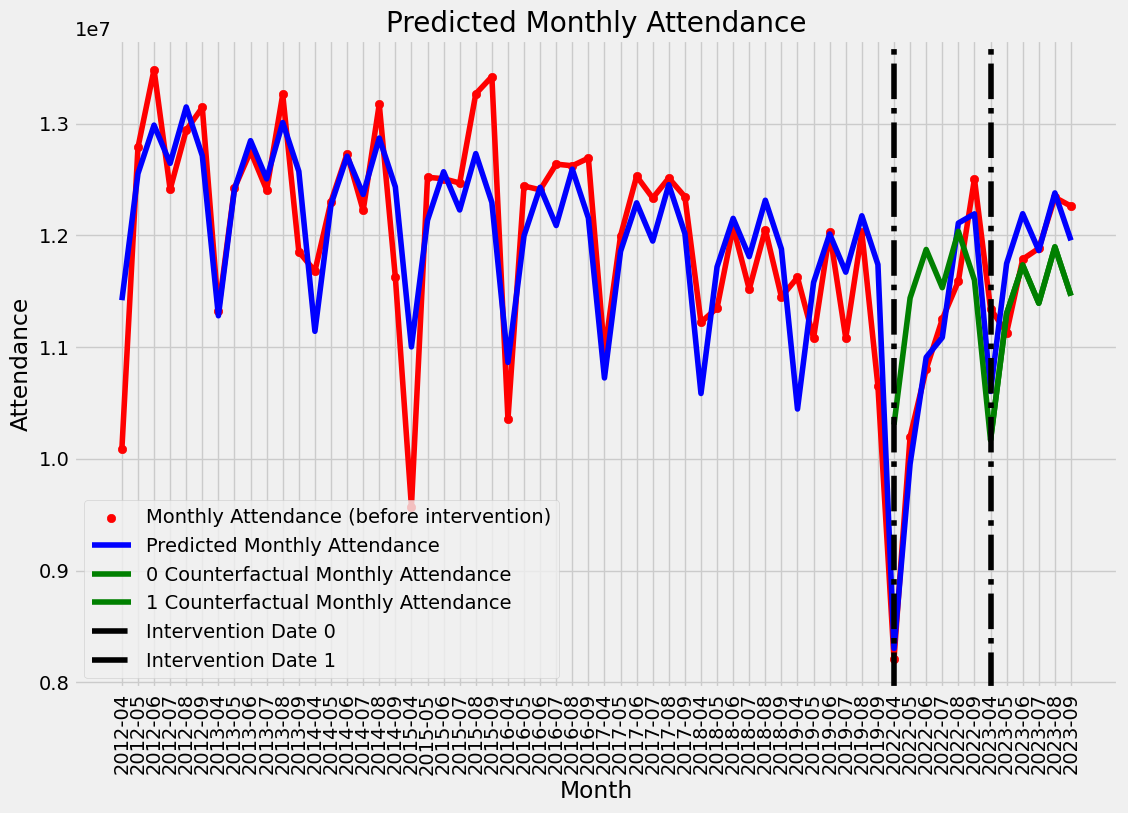

In [171]:
test_mits.plot_predict(is_counterfactual=True)

In [172]:
test_mits.fit_slope_after_intervention()

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     7.729
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           1.53e-05
Time:                        01:05:45   Log-Likelihood:                -896.34
No. Observations:                  60   AIC:                             1805.
Df Residuals:                      54   BIC:                             1817.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [162]:
test_mits.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     5.986
Date:                Mon, 23 Oct 2023   Prob (F-statistic):           4.89e-06
Time:                        01:02:55   Log-Likelihood:                -886.62
No. Observations:                  60   AIC:                             1797.
Df Residuals:                      48   BIC:                             1822.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.261e+07   2.12e+05     59.532      0.000    1.22e+07     1.3e+07
time since start  -2.13e+04   7576.608     -2.811      0.007   -3.65e+04   -6065.093
level change 0   -3.019e+06   7.57e+05     -3.991      0.000   -4.54e+06    -1.5e+06
slope change 0    6.478e+05   1.86e+05      3.489      0.001    2.74e+05    1.02e+06
level change 1   -9.568e+05   9.06e+05     -1.056      0.296   -2.78e+06    8.65e+05
slope change 1   -5.085e+05   2.67e+05     -1.901      0.063   -1.05e+06    2.92e+04
sin(1,12)         8371.5192   1.45e+05      0.058      0.954   -2.82e+05    2.99e+05
cos(1,12)          1.42e+04   1.44e+05      0.098      0.922   -2.76e+05    3.04e+05
sin(2,12)        -8.566e+04   1.37e+05     -0.624      0.535   -3.62e+05     1.9e+05
cos(2,12)        -5.494e+05   1.32e+05     -4.165      0.000   -8.15e+05   -2.84e+05
sin(3,12)         4.014e+04    1.3e+05      0.308      0.759   -2.22e+05    3.02e+05
cos(3,12)        -1.141e+05    1.3e+05     -0.875      0.386   -3.76e+05    1.48e+05
==============================================================================
Omnibus:                       14.012   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.010
Skew:                          -0.902   Prob(JB):                     0.000123
Kurtosis:                       4.988   Cond. No.                         373.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# データが足りないようであれば、仮想的に追加してみて実験してみる？

In [ ]:
分布推定？